# Miscellaneous COVID-19 Data Analyses using CDC Data

Data source:

- <a target="_blank" href="https://www.cdc.gov/nchs/nvss/vsrr/covid19/index.htm">CDC Provisional Death Counts for Coronavirus Disease</a>

The most up-to-date version of this notebook can be found in GitHub repository <https://github.com/bmc/covid19/>.


In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
from datetime import datetime, timedelta, date
import csv
import os
import re
import math
from lib.common import *

matplotlib.__version__

'3.2.1'

In [2]:
CDC_DATA_PATH = 'data/cdc/Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv'

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)

## CDC data plots

In [4]:
def get_death_counts(state='United States', trim_final_week=True):
    """
    Extract weekly death counts for a particular state or
    for the United States as a whole.
    
    Returns a list of (datetime.date, count) pairs, which the date
    represents the start of a particular week.
    
    NOTE: The final week of the CDC data is automatically trimmed
    (unless trim_final_week is set to False), because experience
    shows that it generally represents partial data, which skews the
    graphs.
    """
    deaths = []
    with open(CDC_DATA_PATH, mode='r', encoding='UTF-8') as f:
        c = csv.DictReader(f)
        for row in c:
            if row['Group'].lower() != 'by week':
                continue
            if row['State'] != state:
                continue
            date = datetime.strptime(row['Start week'], '%m/%d/%Y')
            #today = datetime.now()
            #delta = timedelta(days=7)
            #if date > (today - delta):
            #    continue
            week = datetime.date(date)
            covid_19_deaths = csv_int_field(row, 'COVID-19 Deaths')
            deaths.append((week, covid_19_deaths))

    if trim_final_week:
        deaths = deaths[:-1]

    return deaths

In [5]:
def plot_deaths(deaths, ylabel, image_file_name=None):
    """
    Given a list of (datetime.date, count) pairs, plot them.
    ylabel is the label to be affixed to the Y axis. The X axis
    label is fixed.
    
    The plot will show two lines: total deaths as of a particular
    week (accumulated), and deaths each week.
    """
    deaths_per_week = [d[1] for d in deaths]
    weeks = [datestr(d[0]) for d in deaths]

    fig, ax = p.subplots(figsize=(18, 14))

    # Plot deaths per week.
    ax.plot(weeks, deaths_per_week, markersize=10, color='red', marker='.', label='Deaths per week')
    #annotate_plot(weeks, deaths_per_week, ax)

    # generate weekly sums
    sums = [0 for i in weeks]
    accum = 0
    for i, d in enumerate(deaths_per_week):
        accum += d
        sums[i] = accum

    # Plot the sums
    ax.plot(weeks, sums, markersize=10, color='blue', marker='.', label='Total deaths')
    #annotate_plot(weeks, sums, ax)

    #total_deaths = sum([count for _, count in us_deaths])
    total_deaths = sums[-1]
    textbox(ax, 0.40, 0.90, f"Total deaths in period: {total_deaths:,}\nSource: CDC")

    ax.set_xlabel('Week Ending')
    ax.set_ylabel(ylabel)
    ax.legend()
    
    if image_file_name is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file_name))

    return (fig, ax)


### US-wide deaths per week

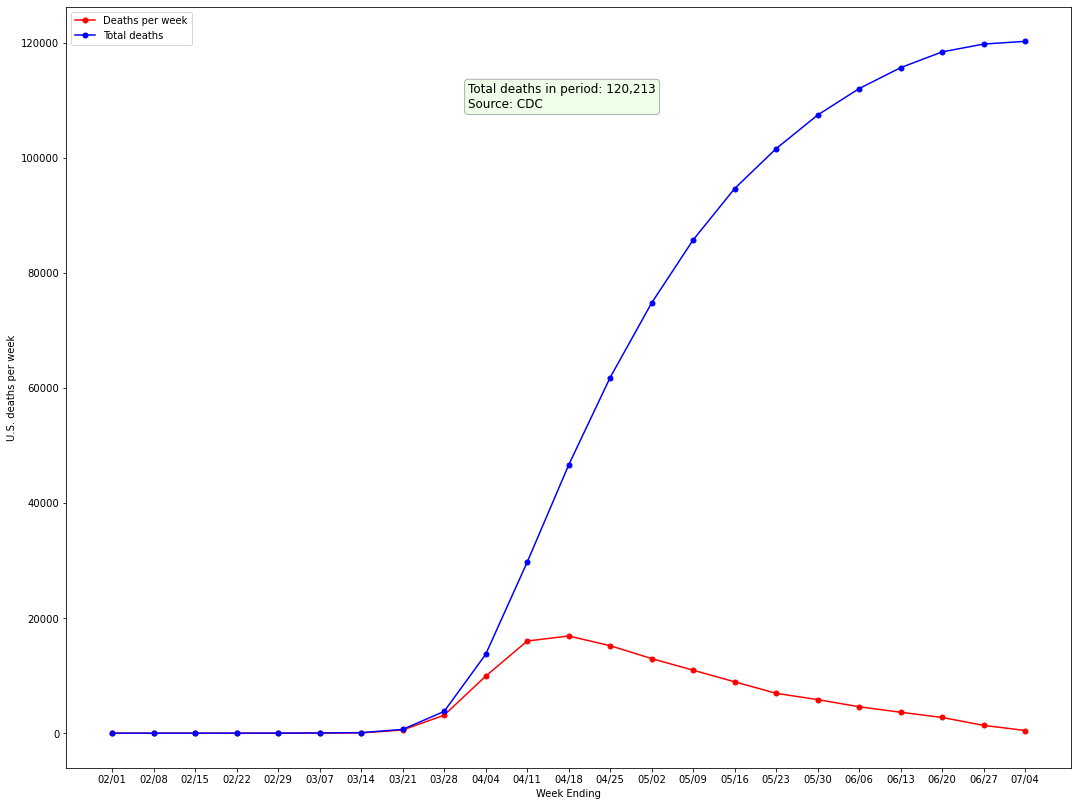

In [6]:
us_deaths = get_death_counts()
fig, ax = plot_deaths(us_deaths, 'U.S. deaths per week', image_file_name='cdc-us-deaths.png')
fig.show()

### Deaths per week, for a number of states

In [7]:
cdc_data = [(get_death_counts(state), state, color, line_style) 
            for state, (color, line_style) in zip(STATES_TO_COMPARE, LINE_COLORS_AND_STYLES)]

#### Some of the bigger-hit states

- California
- Connecticut
- Florida
- Georgia
- Illinois
- Massachusetts
- New York
- Ohio
- Pennsylvania
- Washington


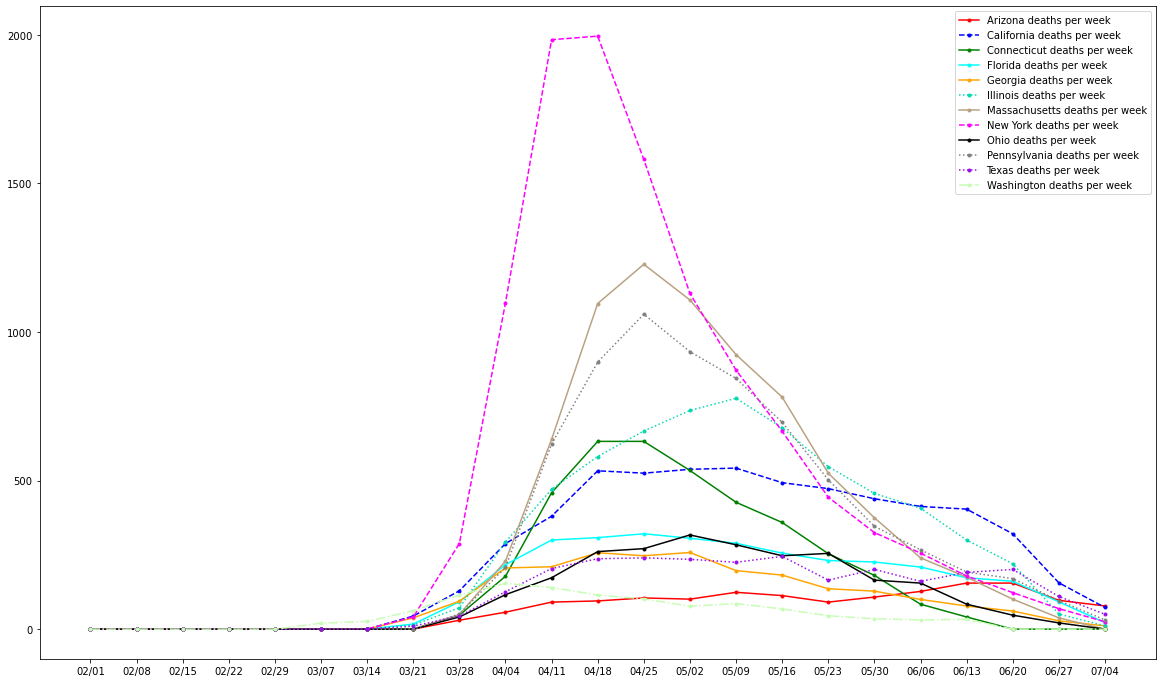

In [9]:
# Line graph.

fig, ax = p.subplots(figsize=(20, 12))

max_deaths = 0
for stats, state, color, line_style in cdc_data:
    deaths_per_week = [count for _, count in stats]
    max_deaths = max(max(deaths_per_week), max_deaths)
    weeks = [datestr(date) for date, _ in stats]

    # Plot deaths per week.
    ax.plot(weeks, deaths_per_week, color=color, marker='.', linestyle=line_style,
           label=f'{state} deaths per week')

ymax, stride = determine_ymax_and_stride(max_deaths)
ax.set_yticks(range(0, ymax)[::stride])
ax.legend()
fig.savefig(os.path.join(IMAGES_PATH, 'cdc-state-comparisons.png'))